In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(imputeLCMD)
    library(rrcovNA)

})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")


ℹ Loading msImpute



In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/txt/evidence.txt", stringsAsFactors = FALSE)

table(data$Type)

# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.Razor.Protein")]
genes <- genes[!duplicated(genes),]


y <- evidenceToMatrix(data) # [grepl("MULTI-MSMS|MULTI-SECPEP", data$Type),]

genes <- genes[match(rownames(y), genes$PeptideID),]

#table(grepl("ups", data$Leading.Razor.Protein))


        MSMS  MULTI-MATCH   MULTI-MSMS MULTI-SECPEP 
        6898        12555        65714         9150 

In [3]:
y_dda <- log2(y)
y <- log2(y)

In [4]:
rownames(y) <- genes$matrix.row.id[match(rownames(y), genes$PeptideID)]
rownames(y_dda) <- genes$matrix.row.id[match(rownames(y_dda), genes$PeptideID)]

In [5]:

keep3 <- (!grepl("CON__|REV__", genes$Leading.Razor.Protein))
keep4 <- (!grepl("[a-z]+", genes$PeptideID))

y_dda <- y_dda[keep3&keep4,]
# y <- normalizeBetweenArrays(log2(y[keep1&keep2,]), method = "quantile")
y <- y[keep3&keep4,]


targets <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/experimentalDesignTemplate.txt")
group <- as.factor(gsub("(.*)-R[123]", "\\1", targets$Experiment))

design <- model.matrix(~ group)

### imputation (barycenter + SOTA methods)

In [6]:
fig.size(4, 6)

y_msImpute <- msImpute(y_dda[rowSums(!is.na(y_dda)) >= 4,], 
                       rank.max = 2,
                       method = "v2-mnar",
                       
                       group = group)



Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 4.14291937968878

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



In [7]:
y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda[(rowSums(!is.na(y_dda)) >= 2),])
y_knn <- impute.wrapper.KNN(y_dda[(rowSums(!is.na(y_dda)) >= 2),], K = 15)




y_perseus <- impute.perseus(y_dda)



# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]



sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD002370_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])

# rowsname <- intersect(rowsname, rownames(y_knn))

# rowsname <- rownames(y_dda)[!(rowSums(is.na(y_dda)) >=2 )]

mats <- list(
             "KNN"= y_knn,
            
             "impSeq" = y_impSeq,
             
             "barycenter" = y_msImpute,
             
             "baseline" = y[(rowSums(!is.na(y)) >= 2),])


mats <- c(sOa_imps, mats)

Cluster size 14679 broken into 3661 11018 
Cluster size 3661 broken into 2057 1604 
Cluster size 2057 broken into 885 1172 
Done cluster 885 
Done cluster 1172 
Done cluster 2057 
Cluster size 1604 broken into 874 730 
Done cluster 874 
Done cluster 730 
Done cluster 1604 
Done cluster 3661 
Cluster size 11018 broken into 6333 4685 
Cluster size 6333 broken into 4854 1479 
Cluster size 4854 broken into 2012 2842 
Cluster size 2012 broken into 644 1368 
Done cluster 644 
Done cluster 1368 
Done cluster 2012 
Cluster size 2842 broken into 1487 1355 
Done cluster 1487 
Done cluster 1355 
Done cluster 2842 
Done cluster 4854 
Done cluster 1479 
Done cluster 6333 
Cluster size 4685 broken into 1267 3418 
Done cluster 1267 
Cluster size 3418 broken into 2000 1418 
Cluster size 2000 broken into 912 1088 
Done cluster 912 
Done cluster 1088 
Done cluster 2000 
Done cluster 1418 
Done cluster 3418 
Done cluster 4685 
Done cluster 11018 


### Differential expression

In [8]:
n_ups <- 500


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   
   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < 0.05,1,0)
  # tp$isUPS <- ifelse(gsub("(.*)_(.*)_(.*)","\\3", rownames(tp)) %in% masterMix_proteins,1,0)
  tp$isUPS <- ifelse(grepl("upsedyp", rownames(tp) ),1,0)
  #tp$isdeUPS <- ifelse(tp$isUPS==1 & tp$de==1,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                      
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > 0.05)[1],1,0),
                                       method=names(mats)[i])
  
  
 

  fullTables[[names(mats)[i]]] <- data.frame(
    
  
    
    # replace with labels and predictions to use pROC
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    
    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))



processing RF



       (Intercept) groupE
Down             0    149
NotSig           0  12628
Up           12827     50


processing Mice



       (Intercept) groupE
Down             0    157
NotSig           0  12609
Up           12827     61


processing EM



       (Intercept) groupE
Down             0    137
NotSig           0  12647
Up           12827     43


processing BPCA



       (Intercept) groupE
Down             0    151
NotSig           0  12623
Up           12827     53


processing KNN



       (Intercept) groupE
Down             0     83
NotSig           0  14591
Up           14679      5


processing impSeq



       (Intercept) groupE
Down             0    161
NotSig           0  14448
Up           14679     70


processing barycenter



       (Intercept) groupE
Down             0    152
NotSig           0  12629
Up           12827     46


processing baseline



       (Intercept) groupE
Down             0    144
NotSig           0  13969
Up           14679     67


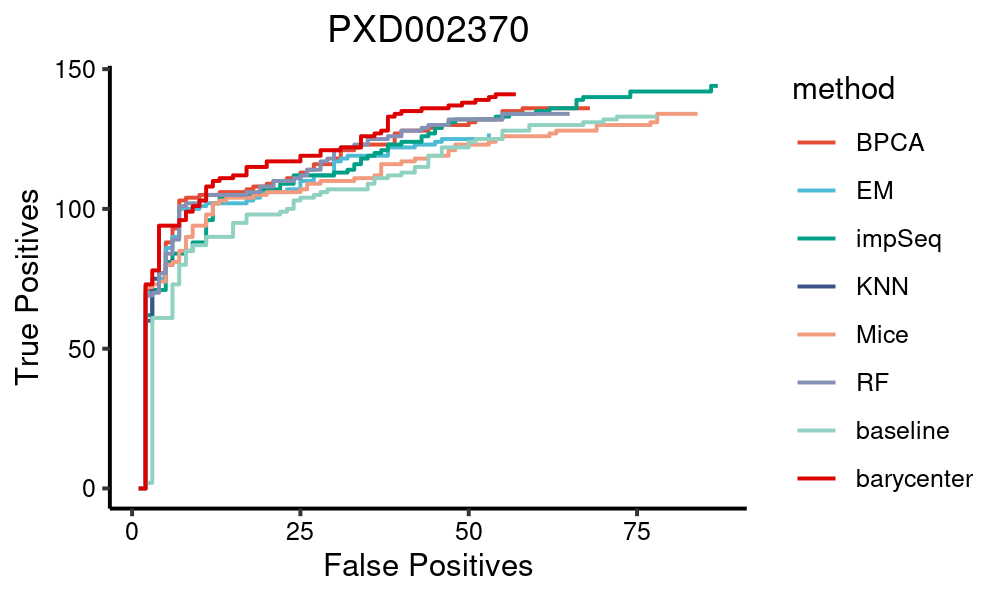

In [9]:
fig.size(3, 5)

# ROC curves

fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))

p1 <- ggplot(fullTables2, aes(y=TP, x=FP, color=method, group = method)) +
#   geom_line(size=1) + 
  geom_line() + 
  scale_color_npg() + 
  #scale_color_simpsons() +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5), axis.text=element_text(colour="black")) + 
  labs(title = "PXD002370") + xlab("False Positives") + ylab("True Positives")

# p1 + p2

p1

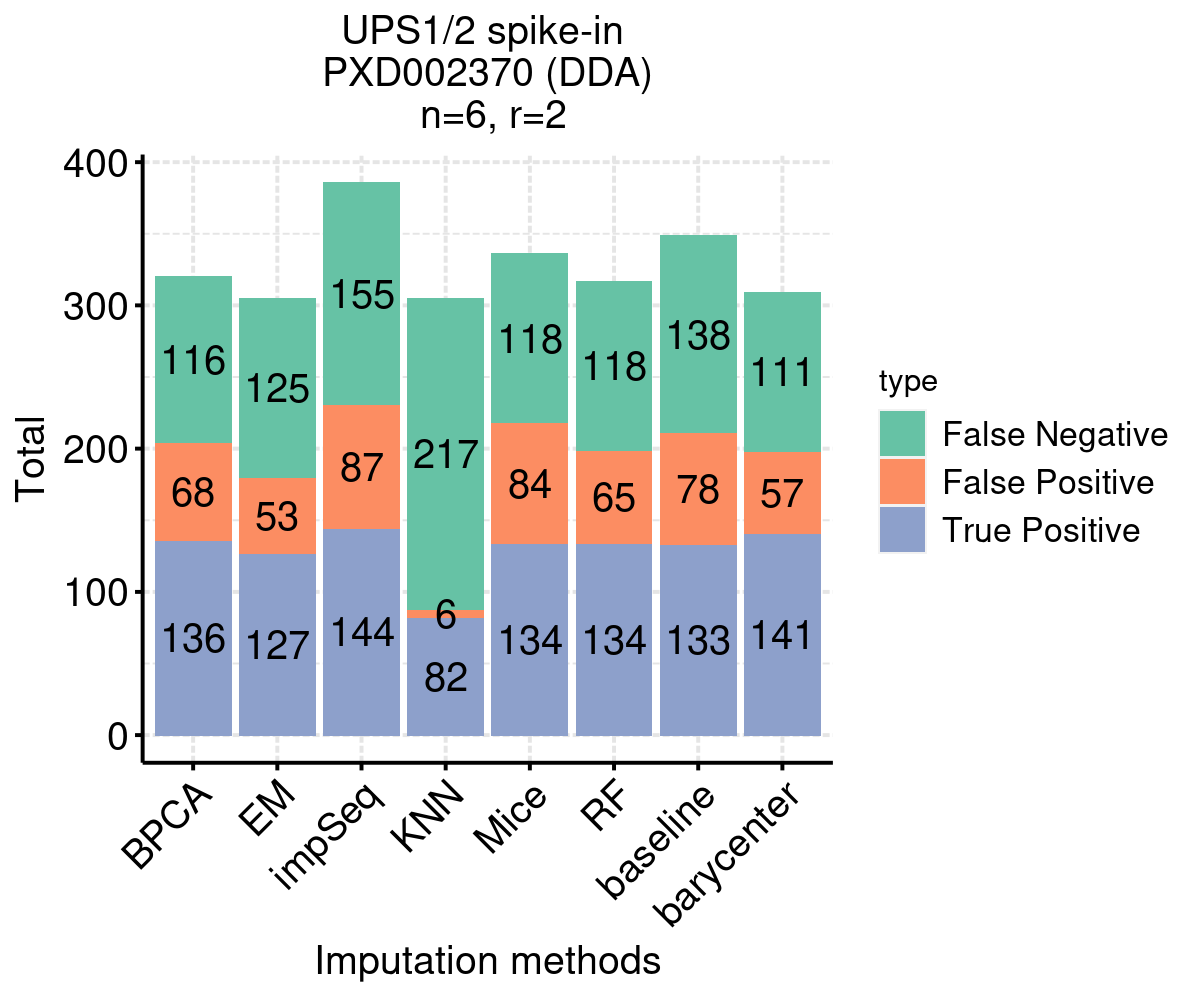

In [10]:
fig.size(5,6)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05

ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)


# png(file = "~/barplot_PXD002370.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  geom_text(size = 5, position = position_stack(vjust = 0.5)) +
  xlab('Imputation methods') + ylab('Total') + labs(fill="type", title = "UPS1/2 spike-in \nPXD002370 (DDA)\n n=6, r=2") +  
  # scale_fill_jco() +
  scale_fill_brewer(palette = "Set2") +
  #scale_fill_brewer(palette = "Dark2", direction = -1) +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p

No NaN EBMs detected. Peptides are missing evenly across samples.

Switchted to 'hvp' method as final msImpute features




FALSE  TRUE 
12327   500 

png 
  2

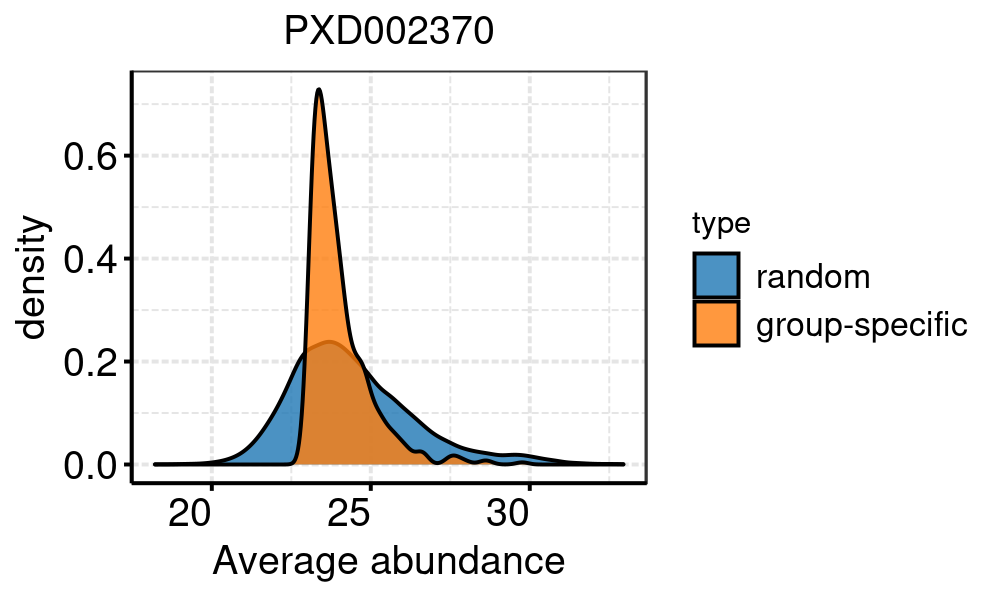

In [11]:
fig.size(3,5)


# Visualization of the ebm metric for assessment of missing types

hdp <- selectFeatures(y_dda[rowSums(!is.na(y_dda)) >= 4,],
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD002370.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD002370", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

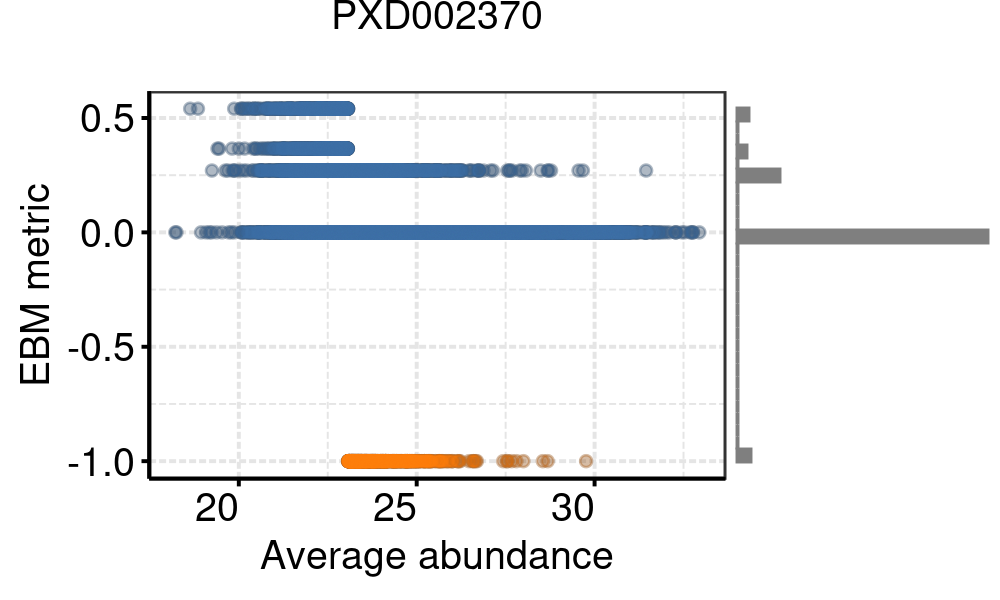

In [12]:
fig.size(3,5)


# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title = 'PXD002370')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PXD002370.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()

p1

### Session information

In [13]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggExtra_0.9         msImpute_1.3.3      rrcovNA_0.4-15     
 [4] rrcov_1.5-5         robustbase_0.93-8   imputeLCMD_2.0     
 [7] impute_1.66.0       pcaMethods_1.84.0   Biobase_2.52.0     
[10] BiocGenerics_0.38